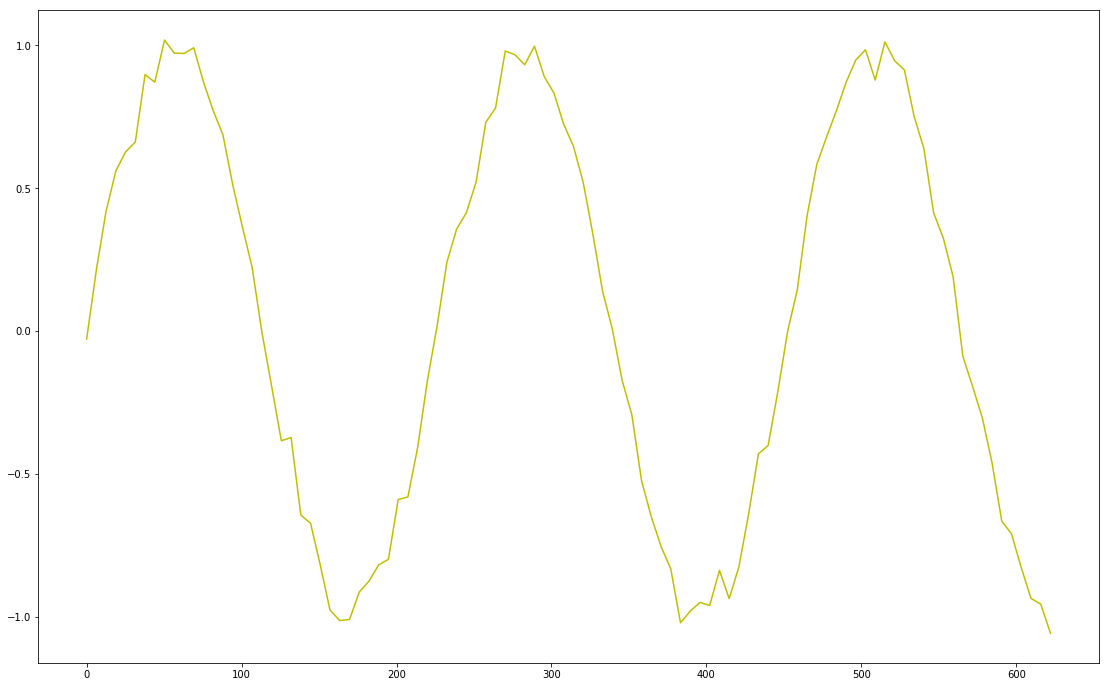

In [1]:
import numpy as np
import math

n = 100
x = [i*2*math.pi for i in range(0,n,1)]
#y = [(i-1)*(i-1) for i in x]
y = [math.sin(i/36) for i in x]
# add noise 
y = [i+np.random.normal(0,0.05) for i in y]
#print(x)
#print(y)

import matplotlib.pyplot as plt

plt.figure(figsize=(19, 12))
plt.plot([i for i in x], [i for i in y], 'y')
plt.show()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11665c510>, '_model_dir': 'Models/model_2', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from Models/model_2/model.ckpt-50000
INFO:tensorflow:Saving checkpoints for 50001 into Models/model_2/model.ckpt.
INFO:tensorflow:loss = 2.17499e-06, step = 50001
INFO:tensorflow:global_step/sec: 352.673
INFO:tensorflow:loss = 2.38989e-06, step = 

INFO:tensorflow:global_step/sec: 359.504
INFO:tensorflow:loss = 2.72696e-06, step = 57301 (0.278 sec)
INFO:tensorflow:global_step/sec: 391.553
INFO:tensorflow:loss = 2.4966e-06, step = 57401 (0.255 sec)
INFO:tensorflow:global_step/sec: 419.308
INFO:tensorflow:loss = 2.69164e-06, step = 57501 (0.238 sec)
INFO:tensorflow:global_step/sec: 484.592
INFO:tensorflow:loss = 2.17119e-06, step = 57601 (0.206 sec)
INFO:tensorflow:global_step/sec: 495.794
INFO:tensorflow:loss = 3.30502e-06, step = 57701 (0.202 sec)
INFO:tensorflow:global_step/sec: 431.618
INFO:tensorflow:loss = 3.86194e-06, step = 57801 (0.232 sec)
INFO:tensorflow:global_step/sec: 497.668
INFO:tensorflow:loss = 2.90917e-06, step = 57901 (0.201 sec)
INFO:tensorflow:global_step/sec: 509.819
INFO:tensorflow:loss = 3.57019e-06, step = 58001 (0.196 sec)
INFO:tensorflow:global_step/sec: 507.197
INFO:tensorflow:loss = 3.44681e-06, step = 58101 (0.197 sec)
INFO:tensorflow:global_step/sec: 389.426
INFO:tensorflow:loss = 2.52749e-06, step =

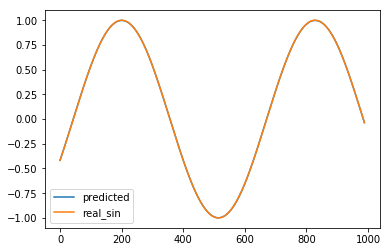

In [2]:
# 以下程序为预测离散化之后的sin函数
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn

# 加载matplotlib工具包，使用该工具包可以对预测的sin函数曲线进行绘图
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
from matplotlib import pyplot as plt

learn = tf.contrib.learn
HIDDEN_SIZE = 30  # Lstm中隐藏节点的个数
NUM_LAYERS = 2  # LSTM的层数
TIMESTEPS = 10  # 循环神经网络的截断长度
TRAINING_STEPS = 10000  # 训练轮数
BATCH_SIZE = 32  # batch大小

TRAINING_EXAMPLES = 10000  # 训练数据个数
TESTING_EXAMPLES = 1000  # 测试数据个数
SAMPLE_GAP = 0.01  # 采样间隔
# 定义生成正弦数据的函数
def generate_data(seq):
    X = []
    Y = []
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入;第i+TIMESTEPS项作为输出
    # 即用sin函数前面的TIMESTPES个点的信息，预测第i+TIMESTEPS个点的函数值
    for i in range(len(seq) - TIMESTEPS - 1):
        X.append([seq[i:i + TIMESTEPS]])
        Y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

def LstmCell():
    lstm_cell = rnn.BasicLSTMCell(HIDDEN_SIZE,state_is_tuple=True)
    return lstm_cell

# 定义lstm模型
def lstm_model(X, y):
    cell = rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])
    # 通过无激活函数的全连接层计算线性回归，并将数据压缩成一维数组结构
    predictions = tf.contrib.layers.fully_connected(output, 1, None)
    
    # 将predictions和labels调整统一的shape
    labels = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])
    
    loss = tf.losses.mean_squared_error(predictions, labels)
    train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                             optimizer="Adagrad",
                                             learning_rate=0.1)
    return predictions, loss, train_op

# 进行训练
# 封装之前定义的lstm
regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir="Models/model_1"))
# 生成数据
test_start = TRAINING_EXAMPLES * SAMPLE_GAP
test_end = (TRAINING_EXAMPLES + TESTING_EXAMPLES) * SAMPLE_GAP
train_X, train_y = generate_data(np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(test_start, test_end, TESTING_EXAMPLES, dtype=np.float32)))
# 拟合数据
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)
# 计算预测值
predicted = [[pred] for pred in regressor.predict(test_X)]

# 计算MSE
rmse = np.sqrt(((predicted - test_y) ** 2).mean(axis=0))
print("Mean Square Error is:%f" % rmse[0])

plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test],['predicted', 'real_sin'])
plt.show()

In [13]:
np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES, dtype=np.float32)).shape

(10000,)

[[ 0.          0.01000083  0.02000067  0.0299985   0.03999333  0.04998416
   0.05997     0.06994984  0.07992267  0.08988751]]
[ 0.09984337]


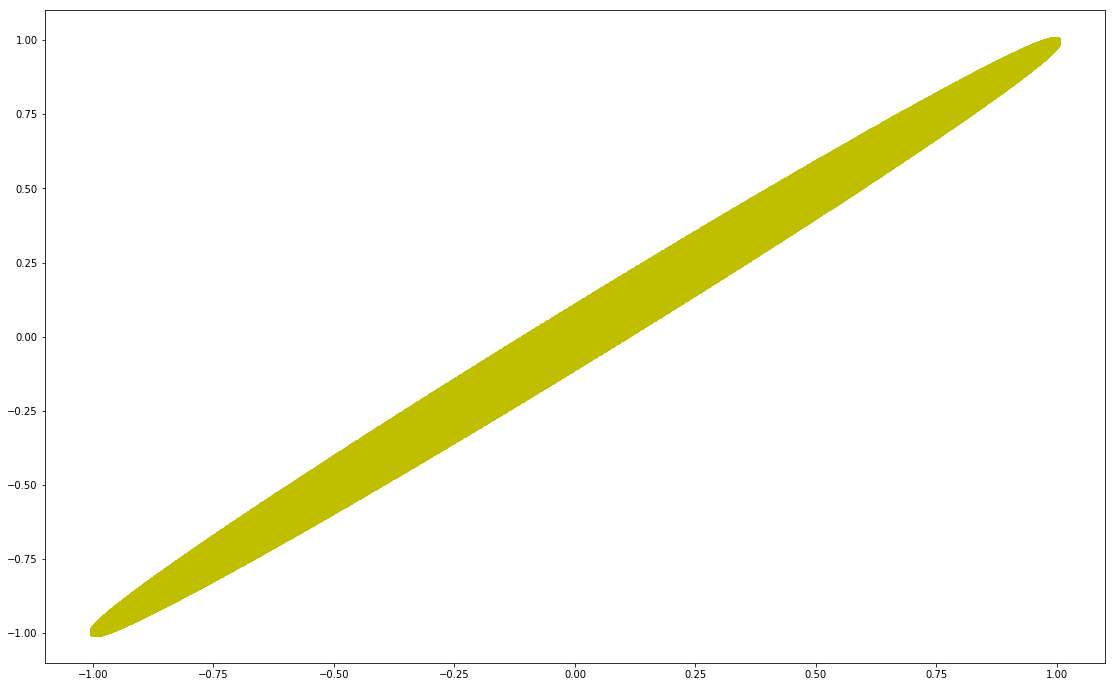

In [15]:
print train_X[0]
print train_y[0]

plt.figure(figsize=(19, 12))
plt.plot([i[0] for i in train_X], [i[0] for i in train_y], 'yo')
plt.show()

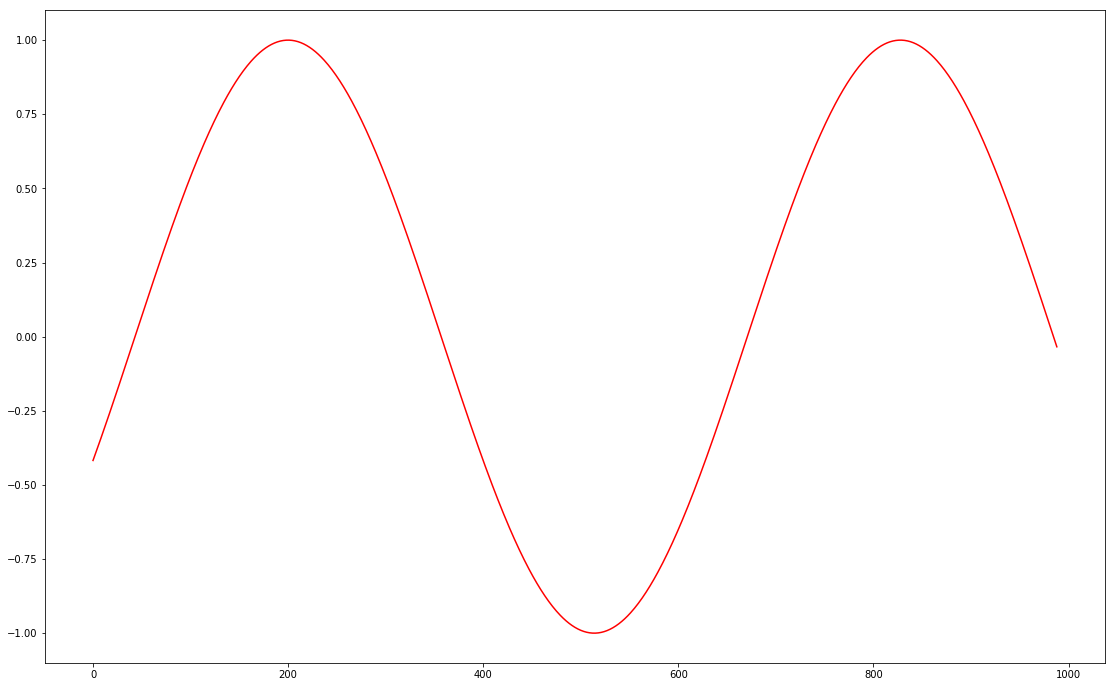

In [8]:
plt.figure(figsize=(19, 12))
# plot_test, = plt.plot(test_y, label='real_sin')
# plot_predicted, = plt.plot(predicted, label='predicted')
# plt.legend([plot_test, plot_predicted],['predicted', 'real_sin'])
# plt.show()

plt.plot([i for i in range(len(test_y))], [i[0] for i in test_y], 'r')
#plt.plot([i for i in range(len(predicted))], [i[0] for i in predicted], 'b')
plt.show()

In [17]:
train_X.shape

(9989, 1, 10)